### Libraries

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle as pkl
from itertools import count
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import tqdm
import os
import pandas as pd
import sys
sys.path.append('../')

In [2]:
# # if you want to run the script on colab, uncomment the following lines
# sys.path.append('./drive/My Drive')
# from google.colab import drive
# drive.mount('/content/drive')
import modules.agents as agents # for different agents
from modules.architectures import BigConvolutionalNetwork # for different architectures
import modules.envs as envs # for Game2048Env
import modules.stats as stats # for plotting results

### Load the agent (train on 10000 matches)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BigConvolutionalNetwork(l2_regularization=3e-4).to(device)


agent = agents.ConvDQN_Agent(model=model,
                        device=device,
                        gamma=0.995,
                        replay_memory_size=10000,
                        batch_size=384,
                        eps_start=0.8,
                        eps_end=0.02, 
                        eps_decay=1000,             
                        tau=5e-3,
                        kind_action="entropy",
                        lr=1e-3)

print("Number of parameters of the Net: ", count_parameters(model))

print("Ignore the warnings, in this case they are ok")

load = True
save = False
num_episodes = 0

env = envs.Game2048Env(log_rewards=True)

if load:
    agent.load("trained_architectures/convdqn_agent_long_train.pt")

if num_episodes > 0:
    agent.fit(env, num_episodes=num_episodes, verbose=True)

if save:
    agent.save("trained_architectures/convdqn_agent_long_train.pt")

Number of parameters of the Net:  211216
Ignore the warnings, in this case they are ok


/home/utente/Scrivania/DS_SC/4th_SEM/Reinforcement_Learning/2048-DRL/modules/agents.py:544: UserWarning: File not found: trained_architectures/action_dist/convdqn_agent_long_train_action_dist.pt. The attribute action_dist will remain unchanged.
  warnings.warn(f"File not found: {save_path}. The attribute {attr} will remain unchanged.")


In [5]:
agent.name = "ConvDQN10000"
agent

Model: ConvDQN_Agent
Steps done 2160636
Memory size 0
Name ConvDQN10000

### Metrics for the Big Convolutional Deep Q-Network

TypeError: no numeric data to plot

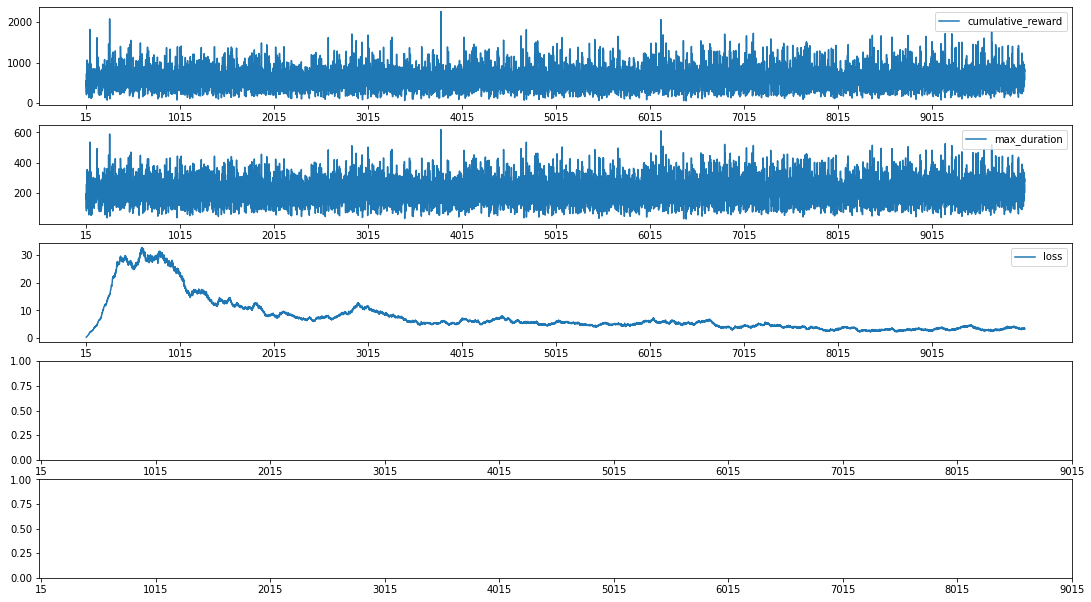

In [6]:
stats.plot_5_metrics(agent, n_ticks=1000)
plt.show()

### Scores of the final agent vs random agent for 500 matches

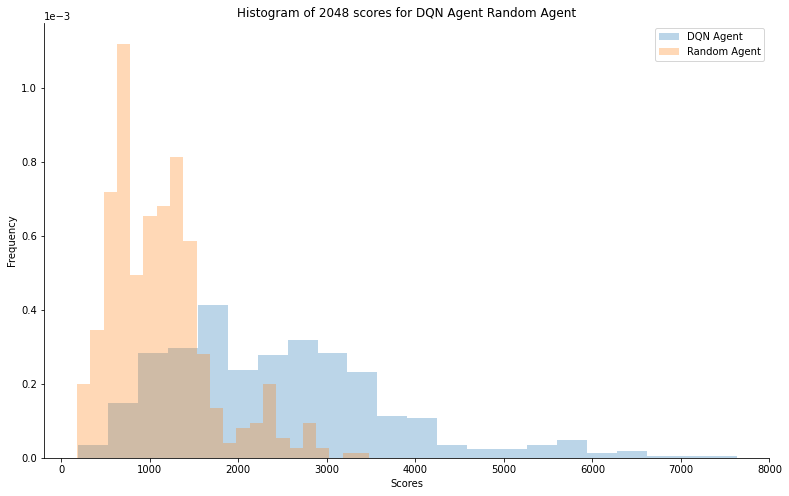

In [ ]:
scores_agent = torch.load("trained_architectures/score/convdqn_agent_500_score_test.pt")
stats.compare_agents(scores_agent)

In [ ]:
duration_agent = torch.load("trained_architectures/max_duration/convdqn_agent_500_duration_test.pt")

### Correlation between score and duration

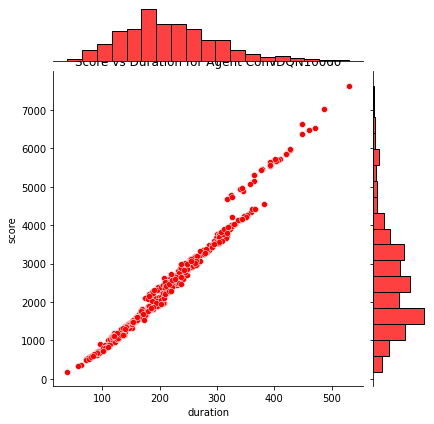

In [ ]:
stats.jointplot_score_duration(scores_agent, duration_agent, agent.name)

### Different Epsilon Greedy strategies

#### Entropy

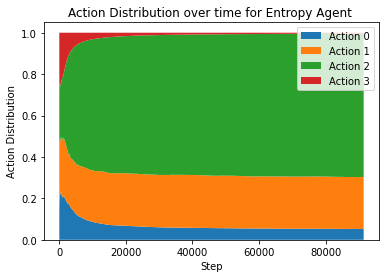

In [13]:
# load action dist with torch.load and assign to agent.action_dist
action_dist_entropy = torch.load("trained_architectures/action_dist/convdqn_agent_300_entropy_action_dist.pt")
action_dist_entropy = np.array(action_dist_entropy)
# stackplot of action distribution
plt.stackplot(np.arange(len(action_dist_entropy)), action_dist_entropy.T, labels=[f"Action {i}" for i in range(4)])
plt.legend(loc='upper right')
plt.xlabel("Step")
plt.ylabel("Action Distribution")
plt.title("Action Distribution over time for Entropy Agent ")
plt.show()

The associated mean board to this agent is the following

![title](images/heatmap_entropy.png)

#### Lai-Robbins

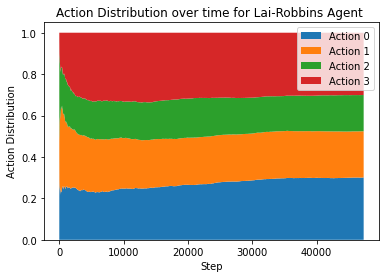

In [16]:
# load action dist with torch.load and assign to agent.action_dist
action_dist_lai_robbins = torch.load("trained_architectures/action_dist/convdqn_agent_300_lairobbins_action_dist.pt")
action_dist_lai_robbins = np.array(action_dist_lai_robbins)
# stackplot of action distribution
plt.stackplot(np.arange(len(action_dist_lai_robbins)), action_dist_lai_robbins.T, labels=[f"Action {i}" for i in range(4)])
plt.legend(loc='upper right')
plt.xlabel("Step")
plt.ylabel("Action Distribution")
plt.title("Action Distribution over time for Lai-Robbins Agent ")
plt.show()

The associated mean board to this agent is the following

![title](images/heatmap_lairobbins.png)

#### Torch-version

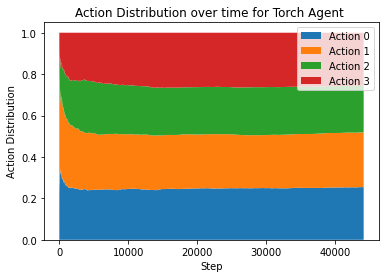

In [17]:
# load action dist with torch.load and assign to agent.action_dist
action_dist_torch = torch.load("trained_architectures/action_dist/convdqn_agent_300_torch_action_dist.pt")
action_dist_torch = np.array(action_dist_torch)
# stackplot of action distribution
plt.stackplot(np.arange(len(action_dist_torch)), action_dist_torch.T, labels=[f"Action {i}" for i in range(4)])
plt.legend(loc='upper right')
plt.xlabel("Step")
plt.ylabel("Action Distribution")
plt.title("Action Distribution over time for Torch Agent ")
plt.show()

The associated mean board to this agent is the following

![title](images/heatmap_torch.png)